In [4]:
from scipy.io import arff
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.stattools import medcouple

plt.rcParams['figure.figsize'] = [15, 7]

In [7]:
arff_file = arff.loadarff('./clusters/artificial/cluto-t4-8k.arff')
df = pd.DataFrame(arff_file[0])

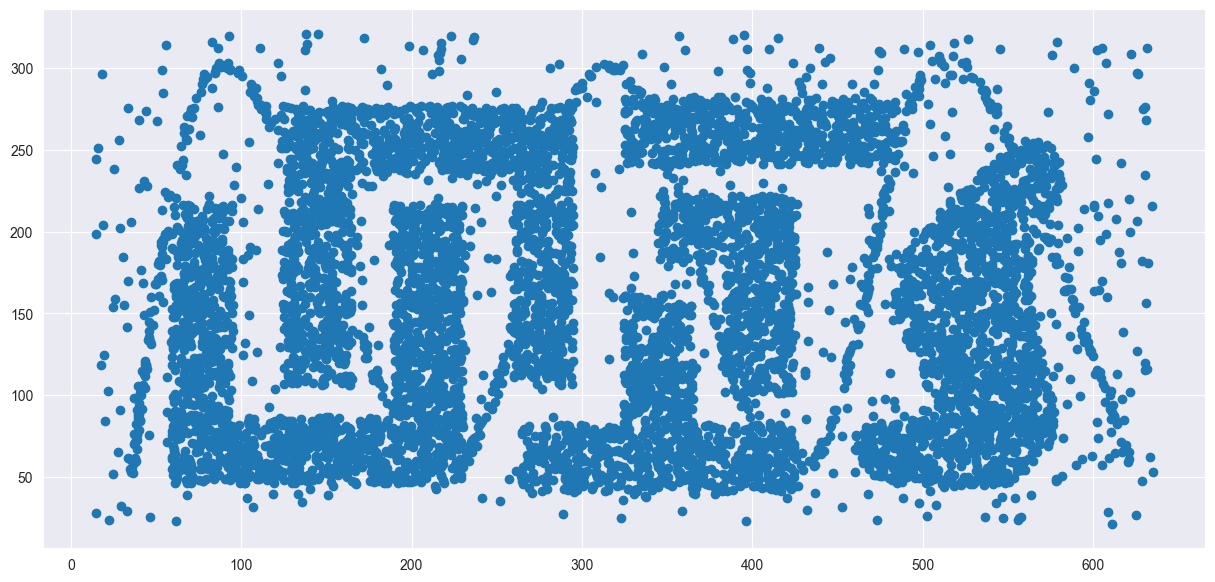

In [8]:
plt.scatter(df['x'],df['y'])
plt.show()